In [71]:
#control parameter fitting
import scipy.optimize
import scipy.signal
import numpy as np

import matplotlib.pyplot as plt
import pandas
import os

import control.matlab as control

#MOTOR EMPIRCAL PARAMS

#voltage supply
PWM_AMPLITUDE = 12
DC_STEPS = [128,256,512,1024]

DATA_DIR_PATH = os.path.join(os.getcwd(),'data')

step_input = 512
df = pandas.read_csv(os.path.join(DATA_DIR_PATH,'2024-04-05', f'2024-04-05_15-41_current_step_response_{step_input}.csv'))

rpm/duty_cycle transfer function 
      5.871e+05
---------------------
s^2 + 22.56 s + 113.1



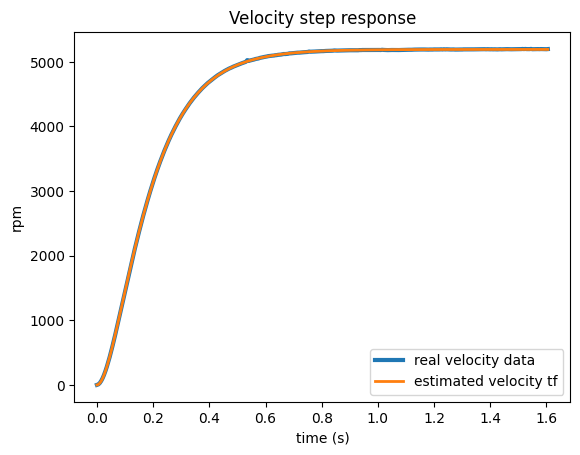

In [77]:
t = df["timestamp_ms"][df['pwm_duty_cycle'] >= step_input].to_numpy()
t=(t-t[0])*1e-3
vel = df["filtered_velocity"][df['pwm_duty_cycle'] >= step_input].to_numpy()

#second order model
def so_model(t,K,wn,zeta):
    tf = control.tf([K],[1,2*wn*zeta,wn**2])
    yout,T = control.step(tf, T=t)
    return yout

[K, wn, zeta],_ = scipy.optimize.curve_fit(so_model, t, vel)
print('rpm/duty_cycle transfer function', control.tf([K],[1,2*wn*zeta,wn**2]))

plt.figure(0)
plt.plot(t, vel, label='real velocity data', linewidth=3)
plt.plot(t,so_model(t, K, wn, zeta), label='estimated velocity tf', linewidth=2)
plt.title("Velocity step response")
plt.xlabel('time (s)')
plt.ylabel('rpm')
plt.legend()

g:\Apps\.python\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
g:\Apps\.python\Lib\site-packages\control\timeresp.py:1056: RuntimeWarning: overflow encountered in matmul
  yout = C @ xout + D @ U
g:\Apps\.python\Lib\site-packages\control\timeresp.py:1056: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U
g:\Apps\.python\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
g:\Apps\.python\Lib\site-packages\scipy\linalg\_matfuncs.py:377: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
g:\Apps\.python\Lib\site-packages\scipy\linalg\_matfuncs.py:377: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


deg/duty_cycle transfer function 
                        1605
----------------------------------------------------
9.734e-09 s^3 + 0.004919 s^2 + 0.05201 s - 0.0005868



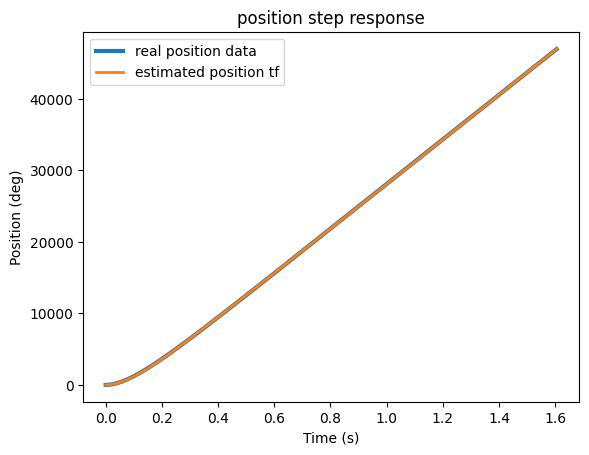

In [73]:
def to_model(t, K, p3, p2, p1, p0):
    tf = control.tf([K],[p3,p2,p1,p0])
    yout, _ = control.step(tf, T=t)
    return yout

pos = df["position"][df['pwm_duty_cycle'] >= step_input].to_numpy()

[K, p3, p2, p1, p0],_ = scipy.optimize.curve_fit(to_model, t, pos)
print('deg/duty_cycle transfer function', control.tf([K],[p3,p2,p1,p0]))

plt.figure(1)
plt.plot(t, pos, label='real position data', linewidth=3)
plt.plot(t, to_model(t, K, p3, p2, p1, p0), label='estimated position tf', linewidth=2)
plt.title("position step response")
plt.xlabel('Time (s)')
plt.ylabel('Position (deg)')
plt.legend()

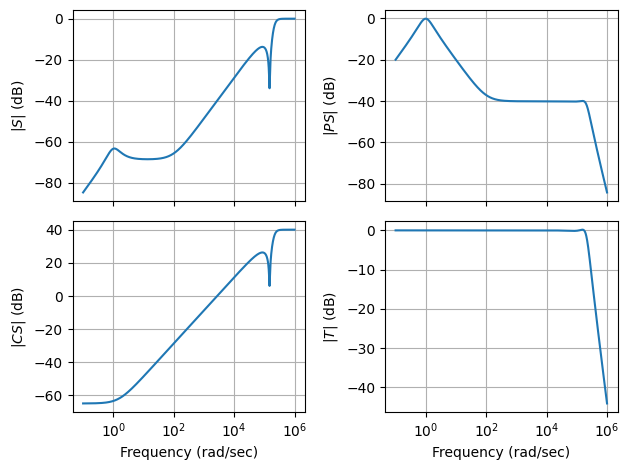

In [95]:
#control tuning for motor position
P = control.tf([K],[p3,p2,p1,p0]) #plant

s = control.tf('s')
#pid controller in continous time
C = (1 + 1/s + s/(0.01*s+1))

control.gangof4(P, C)

estimated Amps/duty_cycle tf 
          7899
------------------------
s^2 + 21.2 s + 1.501e+04

7898.79636041276 122.5226480860745 0.0865204902350706


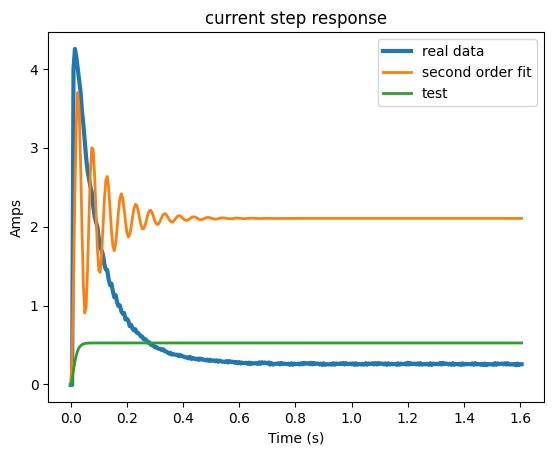

In [123]:
t = df["timestamp_ms"][df['pwm_duty_cycle'] >= step_input].to_numpy()
t=(t-t[0])*1e-3
current = df["current"][df['pwm_duty_cycle'] >= step_input].to_numpy()

#third order model
def model(t,K, wn, zeta):
    tf = control.tf([K],[1,2*wn*zeta,wn**2])
    yout,T = control.step(tf, T=t)
    return yout

[K, wn, zeta],_ = scipy.optimize.curve_fit(model, t, current)
print('estimated Amps/duty_cycle tf', control.tf([K],[1,2*wn*zeta,wn**2]))
print(K,wn,zeta)

plt.plot(t, current, label = 'real data', linewidth=3)
plt.plot(t,model(t, K, wn, zeta), label='second order fit', linewidth=2)
plt.plot(t,model(t, K*5, wn, 0.99), label='test', linewidth=2)
plt.title("current step response")
plt.xlabel('Time (s)')
plt.ylabel('Amps')
plt.legend()